In [1]:
import pandas as pd # 데이터를 처리하기 위한 가장 기본적인 패키지
import re     
import glob
import os
from pandas import DataFrame
from collections import Counter
from konlpy.tag import Twitter
from konlpy.tag import Kkma
from konlpy.tag import Mecab
import numpy as np
import matplotlib as mpl
from wordcloud import WordCloud
import matplotlib.pylab as plt

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = 'C:\\Windows\\Fonts\\malgun.ttf').get_name()
plt.rc('font', family = font_name)
mpl.rcParams['axes.unicode_minus'] = False

from tqdm import tqdm_notebook

### 날짜데이터 정제

In [3]:
## 댓글 파일이 있는 유튜버만 만들어주세요.
df = pd.read_csv('스포츠리스트.csv',encoding='cp949')
name_list = df['이름'].values
print(name_list)

# 전체 유튜버 한번에 돌리는 코드

for name in name_list:
    
    # 각 이름에 맞는 info 파일 불러와서 데이터프레임에 저장
    df = pd.read_csv(f'{name}/{name}_info.csv')


    # column에 Unnames가 새로 생겨서 column 다시 지정해줌
    df.columns = ['', 'name', 'thumbnail', 'view', 'previous_time',
              'video_url', 'start_date', 'comment', 'likes_num', 'unlikes_num', 'time_duration']

    # start_date를 리스트로
    date_list = np.array(df['start_date'])

    # 날짜만 뽑아 오는 정규표현식
    p = re.compile("\d{4}[.]\s\d+[.]\s\d+[.]")

    # 정규표현식에 맞는 날짜 저장할 리스트

    new_date = [] # 정규표현식에 맞는 데이터 배열
    real_date = [] # 리스트 안의 원소만 넣을 리스트

    # 날짜 저장
    for date in date_list:
        new_date.append(re.findall(p, date))

    # 2차원 배열을 1차원 배열로 만들어 줌 (대괄호 안붙게....)

    for i in new_date:
        try:
            real_date.append(i[0])
        except:
            real_date.append('2020. 3. 1.')

    # real_date = np.ravel(new_date)   

    # 데이터프레임의 start_date 컬럼에 값 저장
    df['start_date2'] = real_date
    del df['start_date']

    # info파일 덮어쓰기
    df.to_csv(f'{name}/{name}_info.csv', index = False, encoding = 'utf-8-sig')

    print(f'{name} 저장 완료')

['GoAle' 'JK 아트사커 온라인' 'Minsoo Go' 'ROAD FIGHTING CHAMPIONSHIP'
 'Shoot for Love 슛포러브' 'SomiFit' '강하나스트레칭' '꽁병지tv' '말왕TV' '박문성 달수네라이브'
 '석꾸축꾸' '이스타TV' '재미어트' '차도르' '피지컬갤러리' '흑자헬스SurplusHealth' '힙으뜸']


### 불용어사전 불러오기 및 수정

In [7]:
f= pd.read_csv('불용어사전(한글자).csv',encoding='cp949')
stop_list = list(f)
Unnamed = 'Unnamed: '+ str(len(stop_list)-1)
stop_list.extend(['유튜브','영상','힙으뜸','흑자','빡빡이','혁준','차도르','힘콩','이형','석꾸',
                 '박문성','말왕','병지','강하나','원님','슛포러브','정문홍','제이','케이','알레'])
stop_words = set(stop_list)

stop_words.remove(Unnamed)

# stop_words

# 단어 새로 추가했을 때에 사용!!!
f = open('불용어사전(한글자).csv','w')
for i in stop_words:
    f.write(i+',')
f.close()

### 인코딩 에러뜰 때 순차로 실행('euc-kr' or 'cp949')

In [ ]:
# # #인코딩 에러뜰때만 실행
# youtube_channel = input("유투브 채널 이름 입력하시오.")
# date = pd.read_csv(youtube_channel+'/'+youtube_channel+'_info.csv',encoding='cp949')

In [ ]:
# # #인코딩 에러뜰때만 실행


# date.to_csv(youtube_channel+'/'+youtube_channel+'_info.csv',encoding='utf-8-sig',index=False)

## 텍스트 마이닝 시작

In [9]:
name_list

array(['GoAle', 'JK 아트사커 온라인', 'Minsoo Go', 'ROAD FIGHTING CHAMPIONSHIP',
       'Shoot for Love 슛포러브', 'SomiFit', '강하나스트레칭', '꽁병지tv', '말왕TV',
       '박문성 달수네라이브', '석꾸축꾸', '이스타TV', '재미어트', '차도르', '피지컬갤러리',
       '흑자헬스SurplusHealth', '힙으뜸'], dtype=object)

현재 유튜버 : GoAle
2020. 6. 5.
2020. 6. 4.
2020. 5. 29.
2020. 5. 27.
2020. 5. 26.
2020. 5. 22.
2020. 5. 21.
2020. 5. 20.
2020. 5. 18.
2020. 5. 15.
2020. 5. 14.
2020. 5. 12.
2020. 5. 10.
2020. 5. 8.
2020. 5. 8.
2020. 5. 7.
2020. 5. 4.
2020. 5. 3.
2020. 5. 2.
2020. 5. 1.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


C:\Users\acorn\anaconda3\lib\site-packages\ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\acorn\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')



GoAle date 컬럼 추가 완료
GoAletoken_result 저장 완료


C:\Users\acorn\anaconda3\lib\site-packages\ipykernel_launcher.py:138: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



{'영상': 532, '알레': 514, '호': 403, '축구': 396, '좋은': 259, '항상': 248, '고체': 203, '티노': 201, '선수': 173, '보고': 160, '화이팅': 160, '연습': 158, '형': 151, '역시': 125, '슈팅': 118, '무리뉴': 109, '팬츠': 106, '정말': 102, '오늘': 91, '축구화': 91, '박': 86, '감독': 84, '같아요': 81, '황의조': 81, '가드': 80, '린': 76, '강의': 74, '게임': 74, '슛팅': 71, '꿀팁': 71}


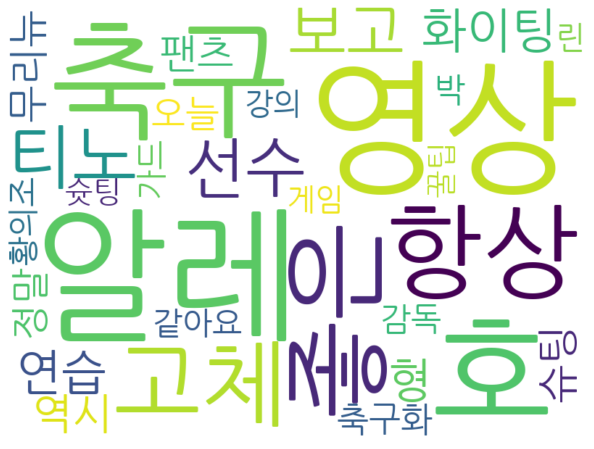

GoAleword cloud 저장 완료
현재 유튜버 : JK 아트사커 온라인
2020. 6. 3.
2020. 5. 30.
2020. 5. 24.
2020. 5. 23.
2020. 5. 19.
2020. 5. 15.
2020. 5. 8.
2020. 5. 2.
2020. 4. 25.
2020. 4. 18.
2020. 4. 14.
2020. 4. 11.
2020. 4. 10.
2020. 4. 4.
2020. 4. 3.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14



JK 아트사커 온라인 date 컬럼 추가 완료
JK 아트사커 온라인token_result 저장 완료



{'축구': 223, '형': 195, '영상': 183, '케이': 90, '로스': 80, '재': 73, '축구화': 73, '보고': 68, '제이': 56, '역시': 52, '코로나': 44, '공': 40, '항상': 39, '회전': 39, '짭드': 38, '슛': 37, '실력': 37, '정말': 35, '무': 35, '오늘': 34, '짜장면': 34, '개': 33, '발': 33, '부': 33, '입니다': 32, '사람': 32, '다시': 31, '사랑': 31, '선수': 30, '다음': 30}


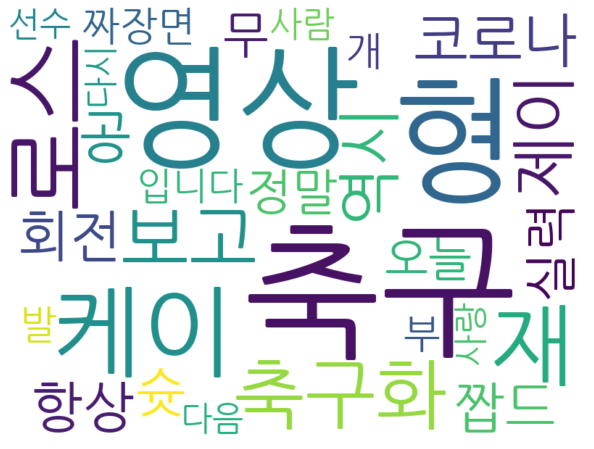

JK 아트사커 온라인word cloud 저장 완료
현재 유튜버 : Minsoo Go
2020. 6. 5.
2020. 6. 4.
2020. 6. 1.
2020. 5. 29.
2020. 5. 26.
2020. 5. 22.
2020. 5. 21.
2020. 5. 19.
2020. 5. 18.
2020. 5. 15.
2020. 5. 14.
2020. 5. 12.
2020. 5. 11.
2020. 5. 8.
2020. 5. 7.
2020. 5. 5.
2020. 5. 1.
2020. 4. 30.
2020. 4. 28.
2020. 4. 27.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



Minsoo Go date 컬럼 추가 완료
Minsoo Gotoken_result 저장 완료



{'운동': 111, '민수': 42, '영상': 26, '오늘': 24, '좋아요': 13, '다이어트': 13, '해': 13, '쌤': 12, '일단': 11, '고민수': 11, '좋은': 11, '샘': 10, '근육': 10, '하루': 10, '보고': 9, '체력': 9, '동기부여': 9, '습관': 9, '요즘': 8, '몸': 8, '세트': 8, '시작': 8, '허벅지': 8, '집': 8, '입니다': 8, '코로나': 8, '신간': 8, '온라인': 8, '허리': 7, '있는': 7}


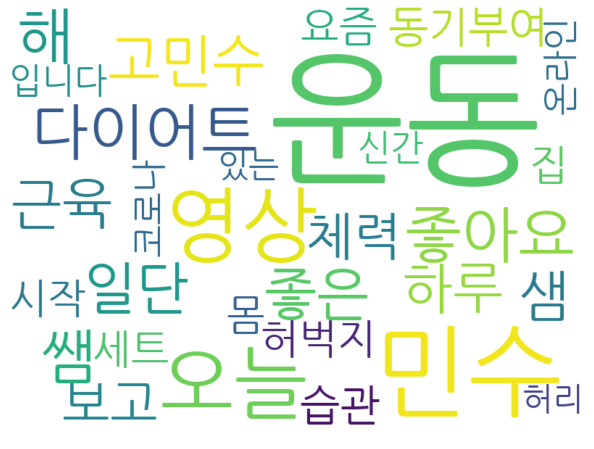

Minsoo Goword cloud 저장 완료
현재 유튜버 : ROAD FIGHTING CHAMPIONSHIP
2020. 6. 5.
2020. 6. 4.
2020. 6. 4.
2020. 6. 4.
2020. 6. 3.
2020. 6. 3.
2020. 6. 2.
2020. 6. 2.
2020. 6. 1.
2020. 5. 29.
2020. 5. 28.
2020. 5. 28.
2020. 5. 28.
2020. 5. 27.
2020. 5. 27.
2020. 5. 27.
2020. 5. 26.
2020. 5. 25.
2020. 5. 25.
2020. 5. 25.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



ROAD FIGHTING CHAMPIONSHIP date 컬럼 추가 완료
ROAD FIGHTING CHAMPIONSHIPtoken_result 저장 완료



{'대표': 20, '홍': 18, '선수': 17, '경기': 15, '해설': 14, '이형': 13, '로드': 11, '가오': 11, '말': 10, '정문': 10, '사람': 9, '입니다': 8, '무농': 8, '룰': 7, '그냥': 7, '격투기': 7, '돈': 6, '정말': 6, '주먹': 5, '가드': 5, '자꾸': 5, '리': 5, '정': 5, '단체': 5, '모습': 4, '싸움': 4, '라운드': 4, '스타일': 4, '형님': 4, '제대로': 4}


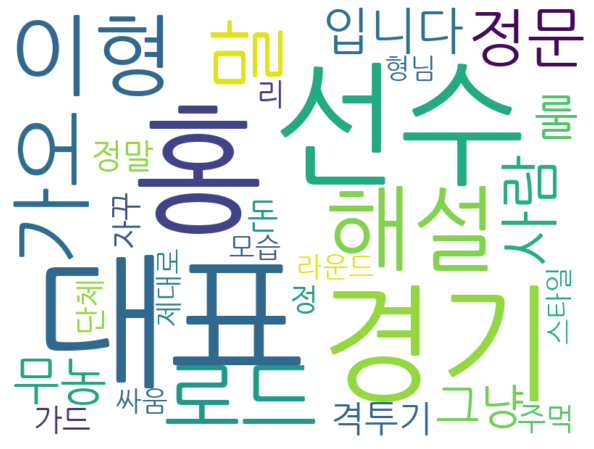

ROAD FIGHTING CHAMPIONSHIPword cloud 저장 완료
현재 유튜버 : Shoot for Love 슛포러브
2020. 6. 3.
2020. 5. 31.
2020. 5. 29.
2020. 5. 26.
2020. 5. 22.
2020. 5. 19.
2020. 5. 15.
2020. 5. 13.
2020. 5. 10.
2020. 5. 8.
2020. 5. 7.
2020. 5. 5.
2020. 5. 3.
2020. 4. 29.
2020. 4. 23.
2020. 4. 20.
2020. 4. 18.
2020. 4. 16.
2020. 4. 14.
2020. 4. 11.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



Shoot for Love 슛포러브 date 컬럼 추가 완료
Shoot for Love 슛포러브token_result 저장 완료



{'러브': 246, '슛포': 240, '선수': 225, '축구': 144, '영상': 133, '골프': 121, '정말': 106, '원희': 98, '표': 98, '누나': 92, '컨텐츠': 77, '감독': 75, '레전드': 74, '화이팅': 70, '조원희': 70, '개': 68, '좋은': 66, '응원': 65, '아이': 64, '보고': 63, '류진': 63, '이제': 61, '시즌': 61, '이영표': 59, '구독': 57, '박인비': 55, '애': 52, '아니': 51, '바밤바': 51, '역시': 51}


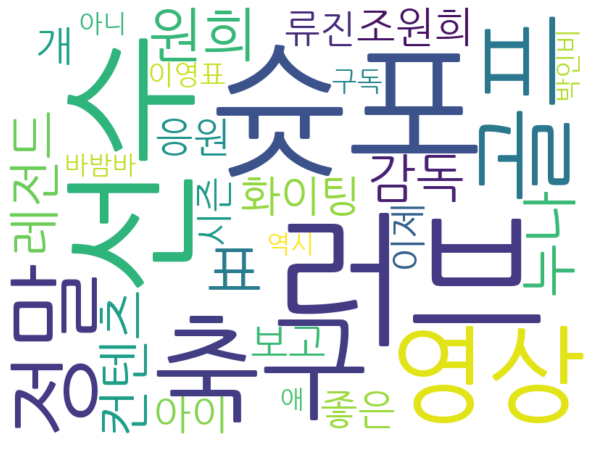

Shoot for Love 슛포러브word cloud 저장 완료
현재 유튜버 : SomiFit
2020. 6. 4.
2020. 6. 1.
2020. 5. 22.
2020. 5. 16.
2020. 5. 15.
2020. 5. 14.
2020. 5. 11.
2020. 5. 9.
2020. 5. 6.
2020. 5. 4.
2020. 5. 2.
2020. 4. 30.
2020. 4. 17.
2020. 4. 13.
2020. 4. 11.
2020. 4. 10.
2020. 4. 9.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16



SomiFit date 컬럼 추가 완료
SomiFittoken_result 저장 완료



{'운동': 533, '영상': 289, '미': 132, '오늘': 96, '좋아요': 93, '코로나': 86, '원님': 69, '미서': 68, '좋은': 67, '땀': 65, '항상': 60, '같아요': 58, '정말': 56, '덤벨': 53, '보고': 52, '쌤': 49, '자극': 49, '입니다': 49, '있어요': 49, '하체': 44, '바이러스': 44, '언니': 43, '매일': 43, '엉덩이': 42, '동작': 41, '세트': 41, '최고': 38, '시작': 37, '선생님': 36, '효과': 36}


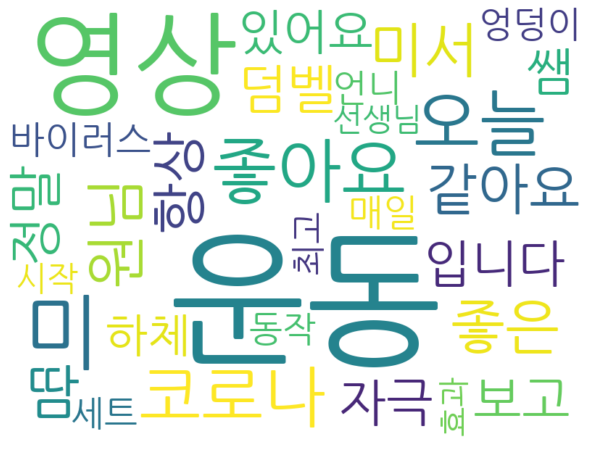

SomiFitword cloud 저장 완료
현재 유튜버 : 강하나스트레칭
2020. 6. 4.
2020. 6. 1.
2020. 5. 28.
2020. 5. 26.
2020. 5. 21.
2020. 5. 18.
2020. 5. 14.
2020. 5. 11.
2020. 5. 7.
2020. 5. 4.
2020. 4. 27.
2020. 4. 23.
2020. 4. 20.
2020. 4. 16.
2020. 4. 13.
2020. 4. 9.
2020. 4. 6.
2020. 4. 2.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17



강하나스트레칭 date 컬럼 추가 완료
강하나스트레칭token_result 저장 완료



{'운동': 423, '영상': 248, '쌤': 246, '선생님': 167, '스트레칭': 164, '하나': 151, '오늘': 137, '다리': 100, '좋아요': 100, '동작': 96, '허벅지': 88, '시작': 84, '매일': 78, '정말': 78, '근육': 68, '항상': 66, '좋은': 64, '자세': 63, '강하나': 62, '몸': 61, '허리': 57, '같아요': 54, '하체': 54, '무릎': 53, '자극': 52, '느낌': 48, '힘': 48, '꾸준히': 48, '땀': 46, '효과': 46}


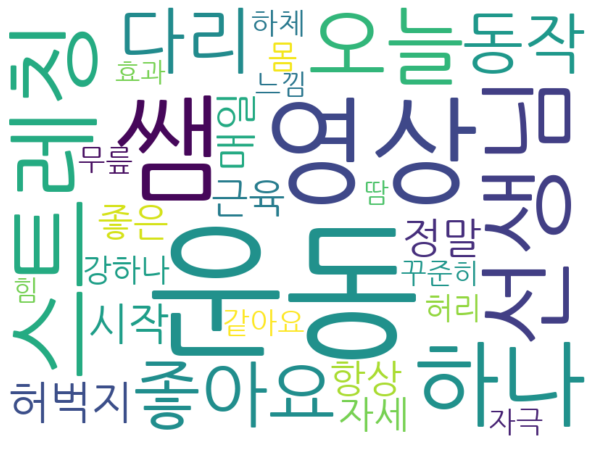

강하나스트레칭word cloud 저장 완료
현재 유튜버 : 꽁병지tv
2020. 6. 5.
2020. 6. 5.
2020. 6. 4.
2020. 6. 2.
2020. 6. 1.
2020. 5. 24.
2020. 5. 22.
2020. 5. 21.
2020. 5. 20.
2020. 5. 19.
2020. 5. 16.
2020. 5. 15.
2020. 5. 14.
2020. 5. 13.
2020. 5. 13.
2020. 5. 12.
2020. 5. 11.
2020. 5. 8.
2020. 5. 7.
2020. 5. 7.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



꽁병지tv date 컬럼 추가 완료
꽁병지tvtoken_result 저장 완료



{'선수': 470, '이강인': 156, '병지': 142, '위': 141, '팀': 126, '감독': 126, '쿠보': 105, '형님': 102, '김병지': 99, '생각': 93, '리그': 91, '축구': 85, '형컴': 80, '무리뉴': 80, '손흥민': 79, '지금': 70, '경기': 63, '골키퍼': 62, '한국': 59, '사람': 58, '최고': 54, '말': 54, '우승': 54, '펩': 54, '골': 53, '수비': 53, '비교': 52, '그냥': 51, '있는': 51, '좋은': 49}


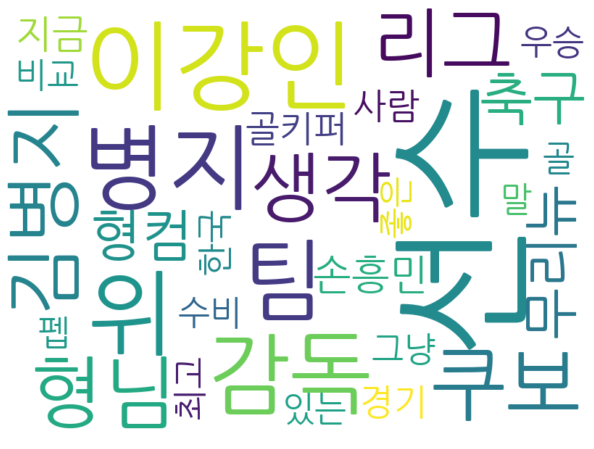

꽁병지tvword cloud 저장 완료
현재 유튜버 : 말왕TV
2020. 6. 2.
2020. 5. 30.
2020. 5. 29.
2020. 5. 26.
2020. 5. 25.
2020. 5. 23.
2020. 5. 20.
2020. 5. 19.
2020. 5. 17.
2020. 5. 15.
2020. 5. 12.
2020. 5. 7.
2020. 5. 4.
2020. 5. 1.
2020. 4. 27.
2020. 4. 25.
2020. 4. 21.
2020. 4. 19.
2020. 4. 15.
2020. 4. 12.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



말왕TV date 컬럼 추가 완료
말왕TVtoken_result 저장 완료



{'형': 427, '말': 339, '운동': 307, '영상': 280, '말왕': 166, '오늘': 85, '보고': 75, '형님': 74, '왕형': 68, '여자': 65, '개': 64, '머리': 64, '웃기': 57, '역시': 56, '여기': 55, '썸네일': 54, '길이': 53, '짱': 51, '이형': 50, '측정': 50, '민교': 48, '아니': 48, '몸': 47, '컬': 45, '사람': 44, '언제': 44, '노래': 43, '벤치': 42, '남자': 39, '여성': 39}


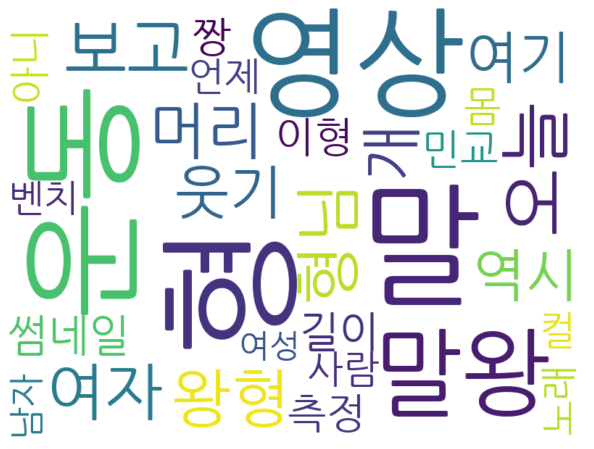

말왕TVword cloud 저장 완료
현재 유튜버 : 박문성 달수네라이브
2020. 6. 6.
2020. 6. 5.
2020. 6. 5.
2020. 6. 4.
2020. 6. 4.
2020. 6. 4.
2020. 6. 3.
2020. 6. 3.
2020. 6. 3.
2020. 6. 1.
2020. 6. 1.
2020. 5. 31.
2020. 5. 29.
2020. 5. 29.
2020. 5. 29.
2020. 5. 28.
2020. 5. 28.
2020. 5. 27.
2020. 5. 26.
2020. 5. 26.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



박문성 달수네라이브 date 컬럼 추가 완료
박문성 달수네라이브token_result 저장 완료



{'선수': 122, '토트넘': 72, '축구': 60, '맨유': 60, '경기': 58, '리그': 51, '영상': 49, '손흥민': 48, '팀': 48, '벌': 47, '챔스': 44, '생각': 43, '뉴캐슬': 41, '업': 40, '팬': 38, '수비': 36, '승': 35, '리버풀': 34, '베르너': 31, '부상': 30, '첼시': 28, '박문성': 28, '시즌': 28, '이강인': 28, '좋은': 27, '말': 27, '지금': 27, '제발': 27, '우승': 27, '코로나': 26}


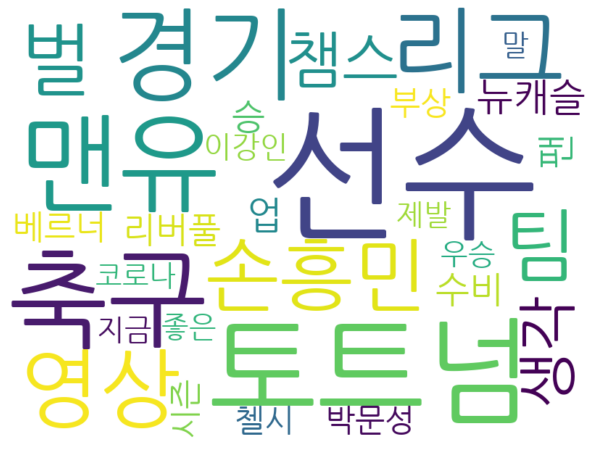

박문성 달수네라이브word cloud 저장 완료
현재 유튜버 : 석꾸축꾸
2020. 4. 4.
2020. 4. 1.
0
1



석꾸축꾸 date 컬럼 추가 완료
석꾸축꾸token_result 저장 완료



{'석': 42, '축구': 40, '꾸': 40, '구독': 40, '이름': 37, '프사': 21, '영상': 17, '독자': 17, '축': 12, '다음': 12, '집': 10, '사람': 9, '난': 9, '좋아요': 9, '형': 8, '화이팅': 8, '오래된': 8, '프로필': 7, '한지': 7, '생각': 6, '배그': 6, '보고': 6, '사랑': 6, '보기': 6, '항상': 6, '오늘': 5, '하루': 5, '종일': 5, '아트': 5, '응원': 5}


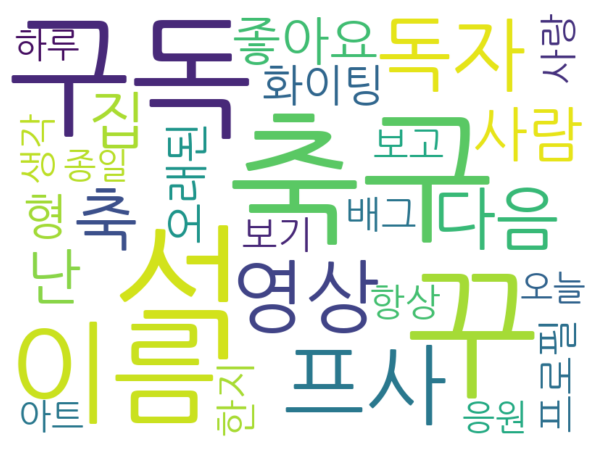

석꾸축꾸word cloud 저장 완료
현재 유튜버 : 이스타TV
2020. 6. 6.
2020. 6. 6.
2020. 6. 6.
2020. 6. 5.
2020. 6. 5.
2020. 6. 5.
2020. 6. 5.
2020. 6. 4.
2020. 6. 4.
2020. 6. 4.
2020. 6. 4.
2020. 6. 3.
2020. 6. 3.
2020. 6. 3.
2020. 6. 3.
2020. 6. 2.
2020. 6. 2.
2020. 6. 2.
2020. 6. 2.
2020. 6. 2.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



이스타TV date 컬럼 추가 완료
이스타TVtoken_result 저장 완료



{'추': 180, '영상': 166, '번개': 145, '형': 137, '선수': 131, '스타': 105, '리버풀': 103, '맨유': 101, '생각': 92, '이형': 85, '컨텐츠': 79, '종윤': 74, '팬': 74, '첼시': 72, '보고': 70, '볼': 69, '말': 69, '맨': 65, '코비': 65, '팀': 62, '개': 61, '축구': 58, '사람': 57, '시즌': 54, '이니에스타': 54, '우먼': 52, '오늘': 52, '베르너': 51, '전범': 48, '쿠티뉴': 45}


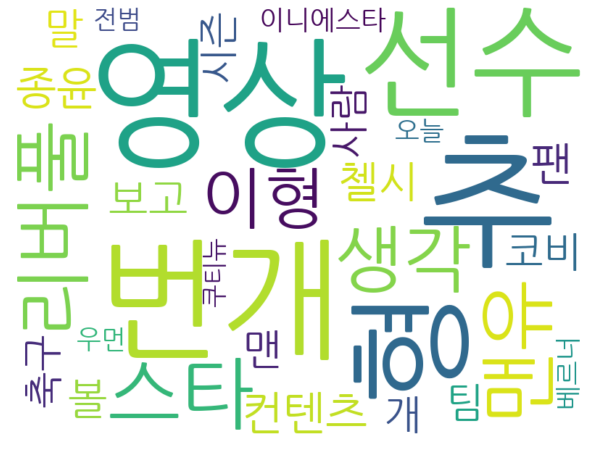

이스타TVword cloud 저장 완료
현재 유튜버 : 재미어트
2020. 6. 4.
2020. 6. 2.
2020. 5. 28.
2020. 5. 19.
2020. 5. 17.
2020. 5. 12.
2020. 5. 7.
2020. 5. 5.
2020. 4. 30.
2020. 4. 29.
2020. 4. 28.
2020. 4. 23.
2020. 4. 21.
2020. 4. 13.
2020. 4. 2.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14



재미어트 date 컬럼 추가 완료
재미어트token_result 저장 완료



{'운동': 153, '형': 120, '힘콩': 98, '영상': 64, '입니다': 39, '몸': 36, '하체': 34, '시작': 34, '형님': 28, '키': 28, '보고': 28, '개': 25, '생각': 25, '살': 24, '사람': 24, '다이어트': 24, '말': 22, '습관': 22, '좋은': 22, '재미': 21, '오늘': 21, '지금': 21, '정말': 21, '체': 20, '몸무게': 19, '신청': 19, '트': 19, '가슴': 18, '정도': 17, '다운': 17}


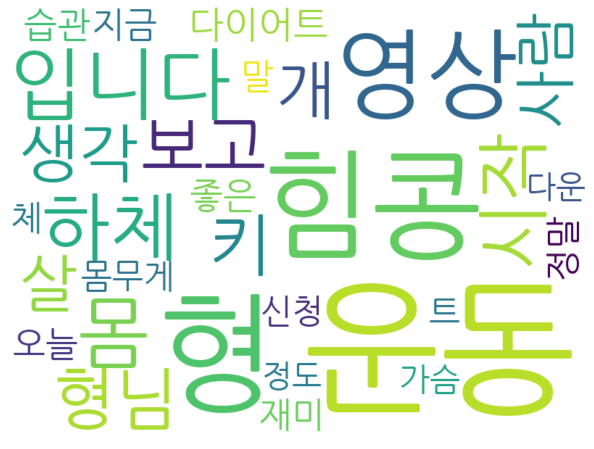

재미어트word cloud 저장 완료
현재 유튜버 : 차도르
2020. 5. 23.
2020. 5. 22.
2020. 5. 21.
2020. 5. 20.
2020. 5. 19.
2020. 5. 17.
2020. 5. 16.
2020. 5. 15.
2020. 5. 14.
2020. 5. 13.
2020. 5. 13.
0
1
2
3
4
5
6
7
8
9
10



차도르 date 컬럼 추가 완료
차도르token_result 저장 완료



{'디아즈': 64, '선수': 64, '경기': 51, '차도르': 34, '마스': 29, '닉': 28, '트': 27, '영상': 26, '비달': 26, '격투기': 25, '형제': 25, '사람': 19, '아놀드': 19, '약물': 18, '말': 17, '싸움': 16, '상남자': 15, '보고': 15, '그냥': 15, '채널': 15, '대마초': 15, '최고': 14, '정도': 14, '모습': 14, '악동': 14, '형': 14, '응원': 14, '임': 13, '입니다': 13, '키': 13}


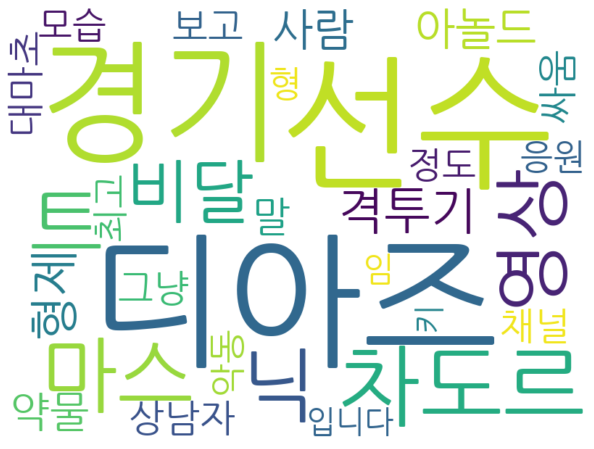

차도르word cloud 저장 완료
현재 유튜버 : 피지컬갤러리
2020. 6. 2.
2020. 6. 1.
2020. 5. 29.
2020. 5. 28.
2020. 5. 26.
2020. 5. 25.
2020. 5. 23.
2020. 5. 21.
2020. 5. 19.
2020. 5. 15.
2020. 5. 14.
2020. 5. 12.
2020. 5. 8.
2020. 5. 5.
2020. 5. 1.
2020. 4. 30.
2020. 4. 28.
2020. 4. 24.
2020. 4. 23.
2020. 4. 21.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



피지컬갤러리 date 컬럼 추가 완료
피지컬갤러리token_result 저장 완료



{'계란': 411, '형': 266, '운동': 216, '혁준': 203, '영상': 197, '빡빡이': 154, '런닝맨': 142, '보고': 114, '오늘': 111, '헌혈': 108, '사람': 106, '김': 103, '마스크': 86, '아저씨': 85, '개': 83, '정말': 71, '컬': 68, '마사지': 68, '피지': 66, '와우': 66, '좋은': 62, '형님': 61, '머리': 59, '공혁준': 57, '썸네일': 55, '친구': 53, '혁준님': 52, '갤러리': 51, '생각': 51, '아니': 50}


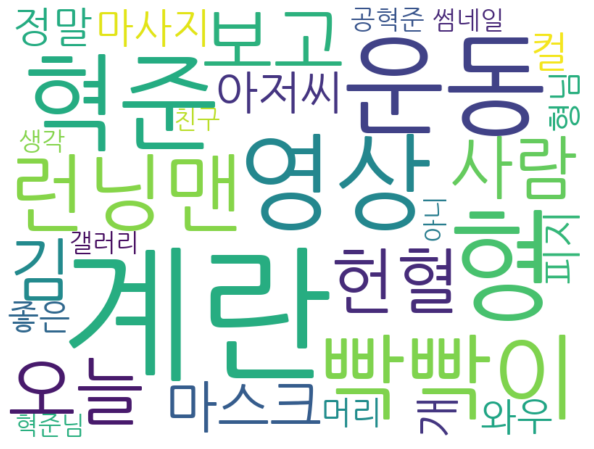

피지컬갤러리word cloud 저장 완료
현재 유튜버 : 흑자헬스SurplusHealth
2020. 6. 1.
2020. 5. 28.
2020. 5. 17.
2020. 5. 15.
2020. 5. 13.
2020. 5. 11.
2020. 5. 9.
2020. 5. 7.
2020. 5. 6.
2020. 4. 30.
2020. 4. 29.
2020. 4. 27.
2020. 4. 24.
2020. 4. 21.
2020. 4. 18.
2020. 4. 16.
2020. 4. 14.
2020. 4. 13.
2020. 4. 11.
2020. 4. 10.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



흑자헬스SurplusHealth date 컬럼 추가 완료
흑자헬스SurplusHealthtoken_result 저장 완료



{'형': 399, '흑자': 350, '영상': 281, '운동': 275, '사람': 177, '말': 148, '몸': 111, '개': 105, '보고': 100, '형님': 89, '선수': 86, '생각': 80, '오늘': 74, '헬스': 74, '입니다': 73, '웃기': 72, '중량': 66, '썸네일': 65, '대니': 62, '좋은': 60, '여자': 60, '얼굴': 60, '그냥': 56, '체육': 56, '임': 56, '마지막': 56, '존나': 53, '근육': 52, '댓글': 51, '아니': 51}


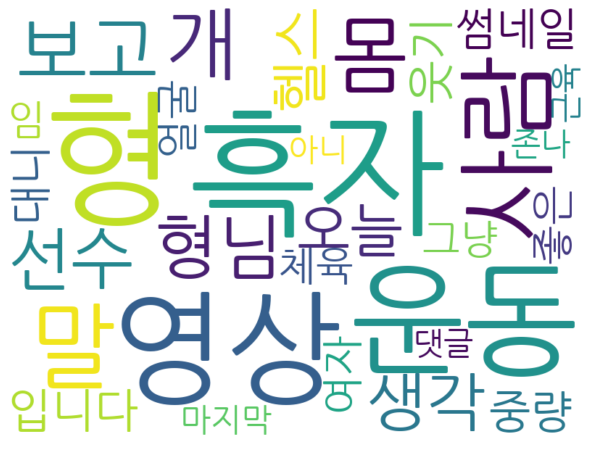

흑자헬스SurplusHealthword cloud 저장 완료
현재 유튜버 : 힙으뜸
2020. 5. 8.
2020. 5. 7.
2020. 5. 4.
2020. 5. 1.
2020. 4. 29.
2020. 4. 28.
2020. 4. 23.
2020. 4. 21.
2020. 4. 17.
2020. 4. 17.
2020. 4. 14.
0
1
2
3
4
5
6
7
8
9
10



힙으뜸 date 컬럼 추가 완료
힙으뜸token_result 저장 완료



{'으뜸': 328, '운동': 211, '영상': 143, '계란': 106, '언니': 103, '스쿼트': 75, '오늘': 67, '개': 53, '같아요': 53, '심': 51, '힙': 49, '세트': 48, '보고': 44, '좋아요': 42, '정말': 41, '바타': 41, '누나': 39, '몸매': 38, '복근': 35, '최고': 34, '사람': 33, '루틴': 32, '몸': 31, '남산': 31, '혁준': 30, '좋은': 29, '땀': 29, '항상': 28, '김': 28, '얼굴': 27}


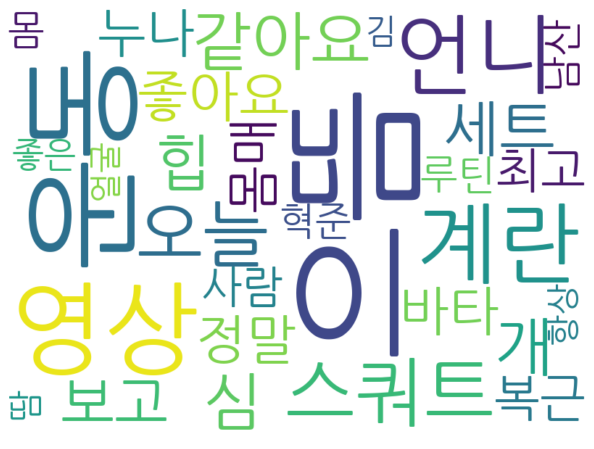

힙으뜸word cloud 저장 완료


In [6]:
# 파일 합치는 곳 (폴더 제목 입력)
# 댓글에 날짜 추가!!!
for youtube_channel in name_list:
#     youtube_channel = input("유투브 채널 이름 입력하시오.")
    youtube_channel = youtube_channel
    print("현재 유튜버 : " + youtube_channel)
#     if youtube_channel :
#     date = pd.read_csv(youtube_channel+'/'+youtube_channel+'_info.csv')
    date = pd.read_csv(youtube_channel+'/'+youtube_channel+'_info.csv')
    ccc = date[date['start_date'] >= '2020. 4. 1']['start_date']

    ccc
    # pd.read_csv('./Beauty/'+youtube_channel+'/comment/'+youtube_channel+'_comment_[i+1].csv')

    for i in ccc:
         print(i)
    #     a = pd.read_csv(('./Beauty/'+youtube_channel+'/comment/'+youtube_channel+'_comment_{}.csv').format(i+1))['youtube'].values
    #     np.append(comment_date, a)     up_date = pd.read_csv(('./Beauty/'+youtube_channel+'/comment/'+youtube_channel+'_comment_{}.csv').format(i+1))
    #     comment_date.append(up_date)
    comment_date = []
    for i in range(len(ccc)):
        print(i)
        a = pd.read_csv((youtube_channel+'/comment/'+youtube_channel+'_comment_{}.csv').format(i+1))
        comment_date.append(a)

#     comment_date[0]
    for i in tqdm_notebook(range(len(ccc))):

        df = comment_date[i]
        you_id = df['youtube_id'].values
        co_id = df['comment'].values
        likes = df['like_num'].values
        start_date = ccc[i]
        comment_final = pd.DataFrame(data = {'닉네임':you_id,
                                    '댓글':co_id,
                                    '좋아요수':likes,
                                    '날짜':start_date})
        comment_final.to_csv(youtube_channel+'/comment/'+ youtube_channel +'_comment_date{}.csv'.format(i+1),
                            encoding='utf-8-sig',index=False)    

    print(youtube_channel + ' date 컬럼 추가 완료')

    path =  str(youtube_channel) + "/comment"
    path2 = str(youtube_channel) + '/result.csv'
    arg_youtube = str(youtube_channel) + "*"


    allFile_list = glob.glob(os.path.join(path,arg_youtube))
    #print(allFile_list)
    allData = []
    for file in allFile_list:
        if 'date' in file:
            # print(file)
            df = pd.read_csv(file)
            allData.append(df)

    dataCombine = pd.concat(allData,axis =0, ignore_index = True)

    dataCombine.to_csv(path2, index = False, encoding = 'utf-8-sig')
    cdPath = str(youtube_channel) + '/result.csv'
    comment_data = pd.read_csv(cdPath)
    comment_data ##제대로 출력되는지 확인
    com_list = list(comment_data['댓글'])   ##제대로 출력되는지 확인
    # com_list   ##제대로 출력되는지 확인

    # ### 추출된 단어가 무슨 형태인지 파악
    # # for sentence in com_list:
    # #     morph = twitter.pos(sentence)
    # #     sentences_tag.append(morph)

    # 추출 단어들 저장

    def get_noun(comment_txt):

        twitter = Twitter()
        noun_list = []

        if len(comment_txt) > 0:
            twitter = twitter.pos(comment_txt, norm = True, stem = True)
            for word, tag in twitter:
                if tag in ['Noun']:

                    if word not in stop_words:
                        noun_list.append(word)

        return noun_list

    def get_adj(comment_txt):

        twitter = Twitter()
        adj_list = []

        if len(comment_txt) > 0:
            twitter = twitter.pos(comment_txt, norm = True, stem = True)
            for word, tag in twitter:
                if tag in ['Adjective']:
                    if word not in stop_words:
                        adj_list.append(word)

        return adj_list

    def get_verb(comment_txt):

        twitter = Twitter()
        verb_list = []

        if len(comment_txt) > 0:
            twitter = twitter.pos(comment_txt, norm = True, stem = True)
            for word, tag in twitter:
                if tag in ['Verb']:
                    if word not in stop_words:
                        verb_list.append(word)
        return verb_list

    comment_list = []
    for i in range(len(comment_data)):
        comment_list.append(comment_data['댓글'].iloc[i])

    comment_result = []

    for i in comment_list:
        comment_result.append(i)

    comment_result = pd.DataFrame(comment_result, columns=["comment"])

    #cloud.to_file(youtube_channel+'/{}wordcloud.png'.format(youtube_channel)) # 해당폴더에 자동저장
    comment_result['noun'] = comment_result['comment'].apply(lambda x: get_noun(x))
    comment_result['adj'] = comment_result['comment'].apply(lambda x: get_adj(x))
    comment_result['verb'] = comment_result['comment'].apply(lambda x: get_verb(x))

    comment_result.to_csv(youtube_channel +'/{}token_result.csv'.format(youtube_channel),
                                                                       index = False, encoding = 'utf-8-sig')
    print(youtube_channel + 'token_result 저장 완료')

    twitter = Twitter()

    sentences_tag = []
    for sentence in tqdm_notebook(com_list):
        morph = twitter.pos(sentence)
        sentences_tag.append(morph)

    stop_words
    for sentence in comment_data:
        morph = twitter.pos(sentence)
        sentences_tag.append(morph)
    #     print(morph)
    #     print('-'*30)

    # print(sentences_tag)
    # print(len(sentences_tag))
    # print('\n'*3)

    noun_adj_list = []
    for sentence1 in sentences_tag:
        for word, tag in sentence1:
            if tag in ['Noun','Adjective','verb']:
                if word not in stop_words:
                    noun_adj_list.append(word)            

    counts = Counter(noun_adj_list)
    select_data = counts.most_common(30)


    wc = WordCloud(font_path='NanumGothic.ttf',max_font_size=200,background_color='white' ,width=800, height=600)

    print(dict(select_data))
    cloud = wc.generate_from_frequencies(dict(select_data))
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(cloud,interpolation='bilinear')
    plt.show()
    cloud.to_file(youtube_channel+'/{}wordcloud.png'.format(youtube_channel)) # 해당폴더에 자동저장
    
    print(youtube_channel + 'word cloud 저장 완료')

In [10]:
## 댓글 파일이 있는 유튜버만 만들어주세요.
df = pd.read_csv('스포츠리스트.csv',encoding='cp949')
name_list = df['이름'].values
name_list

All_file = []
for name in name_list:
# 각 이름에 맞는 info 파일 불러와서 데이터프레임에 저장
    df = pd.read_csv(f'{name}/{name}token_result.csv')
    #df = pd.read_csv(f'C:\\Users\\acorn\\mywork\\pythonwork\\푸드\\{name}token_result.csv')
    All_file.append(df)
    
    dataCombine = pd.concat(All_file,axis =0, ignore_index = True)

    dataCombine.to_csv('testword.csv', index = False)

In [12]:
aaa= pd.read_csv('testword.csv')
aaa

,comment,noun,adj,verb
0,💥댓글 이벤트💥\r\n댓글을 달아주신 분들 중 추첨을 통해 한 분에게 고알레 7부팬...,"['댓글', '이벤트', '댓글', '중', '추첨', '통해', '알레', '부'...",['궁금하다'],"['달다', '하다', '드리다', '해주다', '들이다', '입다']"
1,1.공을 잘 밀어놓기\n2.디딤발의 위치\n3.임팩트 때 시선\n4.슈팅 후 몸이 ...,"['공', '발의', '위치', '임팩트', '시선', '슈팅', '몸', '역시'...",[],"['자다', '밀다', '디디다', '나가다', '믿다', '보다', '하다', '..."
2,저도 슈팅중에 감아차기를 제일 좋아하고 잘 쓰는데 힘이 안쓸려서 고민이 많았는데 이...,"['슈팅', '차기', '제일', '힘', '고민', '영상', '보고', '법',...","['좋아하다', '많다', '있다', '같다']","['감다', '자다', '쓰다', '쓸리다', '힘쓰다', '되다', '감다', '..."
3,고알레 하루도 빠짐없이 시청합니다.\n아마추어 축구인들의 길라잡이라할까요?\n고알레...,"['알레', '하루', '시청', '아마추어', '축구인', '길라잡이', '알레'...","['많다', '유익하다']","['빠지다', '하다', '하다', '감사하다', '하다', '바꾸다', '되다',..."
4,고체티노가 알려주니까 카카pd가\n잘차네..,"['고체', '티노', '카카']",[],"['알다', '가다', '차다']"
...,...,...,...,...
29836,계란형 콜라보 잼나요.\n평균 남성이면 보통 몇 정도가 맞을까요.\n음....30키...,"['계란', '콜라보', '평균', '남성', '이면', '보통', '정도', '음...","['가능하다', '이쁘다', '좋다', '좋다', '좋다']","['재다', '맞다', '업다', '감사하다']"
29837,나도 빡빡이아저씨야,"['빡빡이', '아저씨']",[],['나다']
29838,쌕시한 레깅스입은 사람이 계속 코어에 힘주라는데 코어가먼가요??,"['쌕', '시한', '레깅스', '사람', '계속', '코어', '코어', '무엇']",[],"['입다', '힘주다']"
29839,"언젠가부터 으뜸님, 계란형, 공혁준 세 사람이 함께 나오지 않으면 어색함. 이게 누...","['부터', '으뜸', '계란', '공혁준', '세', '사람', '누구', '채널...","['어색하다', '헷갈리다', '아니다']","['나오다', '않다', '이다', '하다', '잠그다', '들리다', '자다', ..."


In [13]:
select_data = aaa.most_common(30)


wc = WordCloud(font_path='NanumGothic.ttf',max_font_size=200,background_color='white' ,width=800, height=600)

print(dict(select_data))
cloud = wc.generate_from_frequencies(dict(select_data))
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(cloud,interpolation='bilinear')
plt.show()
cloud.to_file(youtube_channel+'/{}wordcloud.png'.format(youtube_channel)) # 해당폴더에 자동저장

print(youtube_channel + 'word cloud 저장 완료')

AttributeError: 'DataFrame' object has no attribute 'most_common'